# Train RNN_RNN

In [26]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm

from utils.GloveMgr import GloveMgr
from utils.Dataset import Dataset
from utils.DataLoader import DataLoader
from utils.preprocess_df import preprocess_df
from utils.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn

#from models.RNN_RNN import RNN_RNN

from time import time

import json

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## (Hyper-)parameters

In [3]:
# parameters
cuda_num = 0
embed_name = "glove.6B.100"

# hyper-parameters
vocab_size = 150000
batch_size = 32
epochs = 10
learning_rate = 1e-3
model_name = "RNN_RNN"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_proportion_of_sentences_per_document = 0.2670278281534701
average_number_of_sentences_per_document = 6.061850780738518

## PyTorch initialisation

In [4]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce GTX 1650


In [5]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Functions

In [6]:
def average(l):
    return sum(l) / len(l)

## Chargement des données

In [7]:
glovemgr = GloveMgr("./data/glove.6B/glove.6B.100d.txt", vocab_size=vocab_size)

In [8]:
train_dataset = Dataset(preprocess_df(pd.read_json("./data/train.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
train_iter = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

In [9]:
val_dataset = Dataset(preprocess_df(pd.read_json("./data/val.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
val_iter = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

## Model

In [10]:
from models.BasicModel import BasicModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class RNN_RNN(BasicModel):
    def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 100):
        super(RNN_RNN, self).__init__(device)

        self.device = device

        self.word_embedding = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)
        # Load word embedding if specified
        if word_embed is not None:
            self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

        # 100 : word2vec embedding size
        self.word_GRU = nn.GRU(input_size = dim_word_embed, hidden_size = 200, batch_first = True, bidirectional = True)
        self.sent_GRU = nn.GRU(input_size = 2*200, hidden_size=200, batch_first = True, bidirectional = True)

        # 10: relative position range size, with segment size = 10
        self.rel_pos_emb = nn.Embedding(11, 100)
        self.abs_pos_emb = nn.Embedding(100, 100)

        self.Wdoc = nn.Linear(2*200,2*200,bias=True)

        self.Wcontent = nn.Linear(2*200,1,bias=False)
        self.Wsalience = nn.Bilinear(2*200,2*200,1,bias=False)
        self.Wnovelty = nn.Bilinear(2*200,2*200,1,bias=False)
        self.Wabs_pos = nn.Linear(100,1,bias=False)
        self.Wrel_pos = nn.Linear(100,1,bias=False)
        self.bias = nn.Parameter(torch.empty(1).uniform_(-0.1, 0.1))

    def avg_pool1d(self,x,seq_lens):
        out = []
        for index,t in enumerate(x):
            if seq_lens[index] == 0:
                t = t[:1]
            else:
                t = t[:seq_lens[index],:]
            t = torch.t(t).unsqueeze(0)
            out.append(F.avg_pool1d(t,t.size(2)))
        
        out = torch.cat(out).squeeze(2)
        return out

    def forward(self, arr_x, doc_lens):
        probs = []

        sent_lens = torch.sum(torch.sign(arr_x),dim=1).data
        arr_x = self.word_embedding(arr_x)
        arr_x = self.word_GRU(arr_x)[0]
        arr_x = self.avg_pool1d(arr_x, sent_lens)

        arr_x = self.pad_doc(arr_x, doc_lens)

        arr_x = self.sent_GRU(arr_x)[0]
        docs = self.avg_pool1d(arr_x, doc_lens)

        # for each document, compute probabilities
        for idx, doc_len in enumerate(doc_lens):
            sents = arr_x[idx,:doc_len,:]
            d = torch.tanh(self.Wdoc(docs[idx])).unsqueeze(0)
            s = torch.zeros(1,2*200)
            s = s.to(self.device)
            #prob_doc = []
            for position, h in enumerate(sents):
                h = h.view(1, -1) # resize
                # Compute position embedding
                abs_pos = torch.tensor([[position]], dtype=torch.long)
                abs_pos = abs_pos.to(self.device)
                abs_pos = self.abs_pos_emb(abs_pos).squeeze(0)

                # Compute relative position embedding
                rel_pos = int(round(position / 10))
                rel_pos = torch.tensor([[rel_pos]], dtype=torch.long)
                rel_pos = rel_pos.to(self.device)
                rel_pos = self.rel_pos_emb(rel_pos).squeeze(0)

                # Compute proba
                content = self.Wcontent(h)
                salience = self.Wsalience(h, d)
                novelty = -1 * self.Wnovelty(h,torch.tanh(s))
                ap = self.Wabs_pos(abs_pos)
                rp = self.Wrel_pos(rel_pos)
                prob = torch.sigmoid(content+salience+novelty+ap+rp+self.bias)

                #prob_doc.append(prob)
                probs.append(prob)

                s = s + torch.mm(prob,h)

            #probs.append(torch.tensor(prob_doc))

        probs = torch.cat(probs).squeeze()
        #probs = probs.to(self.device)
        return probs

In [11]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [12]:
model.to(device)

RNN_RNN(
  (word_embedding): Embedding(150002, 100)
  (word_GRU): GRU(100, 200, batch_first=True, bidirectional=True)
  (sent_GRU): GRU(400, 200, batch_first=True, bidirectional=True)
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wdoc): Linear(in_features=400, out_features=400, bias=True)
  (Wcontent): Linear(in_features=400, out_features=1, bias=False)
  (Wsalience): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wnovelty): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [13]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

mae_fn = nn.L1Loss()

## Train

In [14]:
if not os.path.exists(checkpoints_folder):
    os.makedirs(checkpoints_folder)

In [15]:
arr_train_loss = []
arr_train_mae = []
arr_train_acc = []
arr_val_loss = []
arr_val_mae = []
arr_val_acc = []

t1 = time()
for epoch in range(1, epochs+1):
    # train 1 epoch
    model.train()
    nb_batch_train = 0
    total_train_loss = 0
    total_train_mae = 0
    total_train_acc = 0
    with tqdm(train_iter, unit="batch", total=len(train_iter)) as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            features = []
            doc_lens = []

            for j in range(batch_size):
                doc_lens.append(len(batch[j]["doc"]))
                features = features + batch[j]["doc"]
            
            features = torch.tensor(features, dtype=torch.long).to(device)

            targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
            targets = torch.cat(targets)
            targets = targets.to(device)
            
            probs = model(features, doc_lens)
            
            loss = loss_fn(probs, targets)
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            nb_batch_train += 1
            total_train_loss += loss.item()
            total_train_mae += mae_fn(probs, targets).item()
            total_train_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens)
            tepoch.set_postfix(loss=total_train_loss/nb_batch_train, mae=total_train_mae/nb_batch_train, accuracy=total_train_acc/nb_batch_train)
    # Save model
    model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")
    # Show train and val score
    model.eval()
    nb_batch_val = 0
    total_val_loss = 0
    total_val_mae = 0
    total_val_acc = 0
    for i,batch in enumerate(val_iter):
        features = []
        doc_lens = []

        for j in range(batch_size):
            doc_lens.append(len(batch[j]["doc"]))
            features = features + batch[j]["doc"]
            
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
        targets = torch.cat(targets)
        targets = targets.to(device)
        
        probs = model(features, doc_lens)
        loss = loss_fn(probs, targets)
        nb_batch_val += 1
        total_val_loss += loss.item()
        total_val_mae += mae_fn(probs, targets).item()
        total_val_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens)
    print("Epoch {} : train loss = {:.3f}, val loss = {:.3f}, train mae = {:.3f}, val mae = {:.3f}, train accuracy = {:.3f}, val accuracy = {:.3f}".format(epoch, total_train_loss / nb_batch_train, total_val_loss / nb_batch_val, total_train_mae / nb_batch_train, total_val_mae / nb_batch_val, total_train_acc / nb_batch_train, total_val_acc / nb_batch_val))

    arr_train_loss.append(total_train_loss / nb_batch_train)
    arr_train_mae.append(total_train_mae / nb_batch_train)
    arr_train_acc.append(total_train_acc / nb_batch_train)

    arr_val_loss.append(total_val_loss / nb_batch_val)
    arr_val_mae.append(total_val_mae / nb_batch_val)
    arr_val_acc.append(total_val_acc / nb_batch_val)

t2 = time()
print("Training duration =", t2-t1)

Epoch 1: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, accuracy=0.782, loss=0.463, mae=0.255]


Epoch 1 : train loss = 0.463, val loss = 0.377, train mae = 0.255, val mae = 0.225, train accuracy = 0.782, val accuracy = 0.809


Epoch 2: 100%|██████████| 32/32 [00:47<00:00,  1.49s/batch, accuracy=0.81, loss=0.376, mae=0.226] 


Epoch 2 : train loss = 0.376, val loss = 0.360, train mae = 0.226, val mae = 0.223, train accuracy = 0.810, val accuracy = 0.817


Epoch 3: 100%|██████████| 32/32 [00:48<00:00,  1.50s/batch, accuracy=0.812, loss=0.368, mae=0.222]


Epoch 3 : train loss = 0.368, val loss = 0.351, train mae = 0.222, val mae = 0.218, train accuracy = 0.812, val accuracy = 0.822


Epoch 4: 100%|██████████| 32/32 [00:45<00:00,  1.42s/batch, accuracy=0.82, loss=0.358, mae=0.22]  


Epoch 4 : train loss = 0.358, val loss = 0.341, train mae = 0.220, val mae = 0.208, train accuracy = 0.820, val accuracy = 0.830


Epoch 5: 100%|██████████| 32/32 [00:49<00:00,  1.54s/batch, accuracy=0.828, loss=0.346, mae=0.212]


Epoch 5 : train loss = 0.346, val loss = 0.333, train mae = 0.212, val mae = 0.203, train accuracy = 0.828, val accuracy = 0.835


Epoch 6: 100%|██████████| 32/32 [00:49<00:00,  1.55s/batch, accuracy=0.833, loss=0.336, mae=0.205]


Epoch 6 : train loss = 0.336, val loss = 0.314, train mae = 0.205, val mae = 0.200, train accuracy = 0.833, val accuracy = 0.846


Epoch 7: 100%|██████████| 32/32 [00:48<00:00,  1.52s/batch, accuracy=0.841, loss=0.324, mae=0.199]


Epoch 7 : train loss = 0.324, val loss = 0.313, train mae = 0.199, val mae = 0.183, train accuracy = 0.841, val accuracy = 0.849


Epoch 8: 100%|██████████| 32/32 [00:48<00:00,  1.52s/batch, accuracy=0.847, loss=0.317, mae=0.193]


Epoch 8 : train loss = 0.317, val loss = 0.297, train mae = 0.193, val mae = 0.177, train accuracy = 0.847, val accuracy = 0.856


Epoch 9: 100%|██████████| 32/32 [00:48<00:00,  1.53s/batch, accuracy=0.853, loss=0.31, mae=0.186] 


Epoch 9 : train loss = 0.310, val loss = 0.298, train mae = 0.186, val mae = 0.187, train accuracy = 0.853, val accuracy = 0.859


Epoch 10: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, accuracy=0.859, loss=0.294, mae=0.177]


Epoch 10 : train loss = 0.294, val loss = 0.275, train mae = 0.177, val mae = 0.160, train accuracy = 0.859, val accuracy = 0.872
Training duration = 724.7105164527893


In [16]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_mae"]  = arr_train_mae
training_metrics["train_acc"]  = arr_train_acc
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_mae"]    = arr_val_mae
training_metrics["val_acc"]    = arr_val_acc

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
    json.dump(training_metrics, fp)

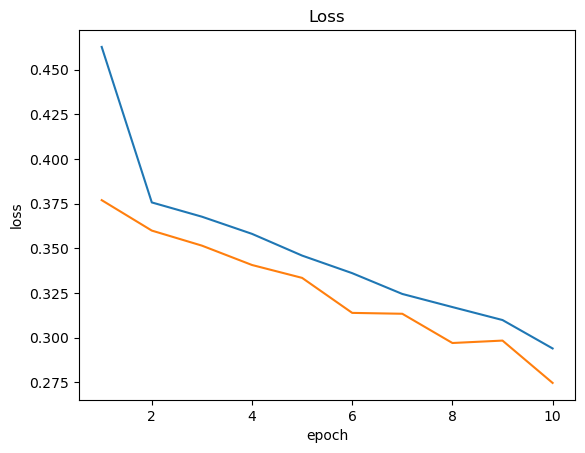

In [23]:
# draw Losses
plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss)
plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss)

plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

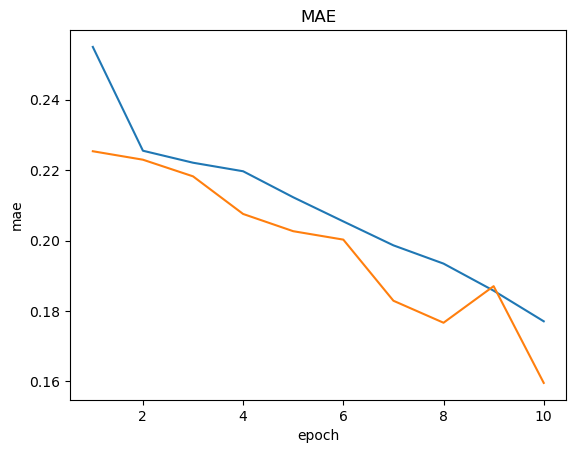

In [22]:
# draw mae
plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae)
plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae)

plt.title("MAE")
plt.xlabel("epoch")
plt.ylabel("mae")

plt.show()

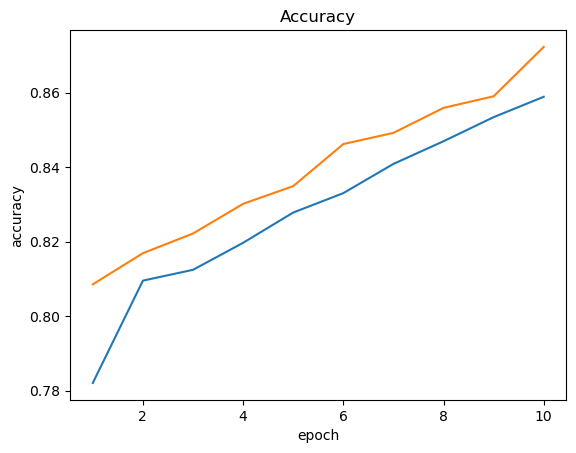

In [21]:
# draw Accuracies
plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc)
plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc)

plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.show()

# Eval model

In [24]:
from utils.split_all_docs import split_all_docs
from rouge_score import rouge_scorer
from utils.threshold_probs import threshold_probs_by_prop

In [25]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [27]:
best_epoch = np.argmax(np.array(arr_val_acc))
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()

RNN_RNN(
  (word_embedding): Embedding(150002, 100)
  (word_GRU): GRU(100, 200, batch_first=True, bidirectional=True)
  (sent_GRU): GRU(400, 200, batch_first=True, bidirectional=True)
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wdoc): Linear(in_features=400, out_features=400, bias=True)
  (Wcontent): Linear(in_features=400, out_features=1, bias=False)
  (Wsalience): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wnovelty): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [28]:
test_set = pd.read_json("./data/test.json")
test_set["doc_splited"] = split_all_docs(test_set["text"])

In [29]:
test_dataset = Dataset(preprocess_df(pd.read_json("./data/test.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
test_iter = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [30]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
mae_fn = nn.L1Loss()

In [31]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
mae = []
accuracy = []

for idx, batch in enumerate(test_iter):
    features = []
    doc_lens = []

    for j in range(1):
        doc_lens.append(len(batch[j]["doc"]))
        features = features + batch[j]["doc"]
            
    features = torch.tensor(features, dtype=torch.long).to(device)

    targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(1)]
    targets = torch.cat(targets)
    targets = targets.to(device)

    probs = model(features, doc_lens)

    doc = test_set["doc_splited"][idx]
    if len(doc) > 1 and len(doc) == probs.shape[0] and probs.shape[0] == targets.shape[0]:
        probs = torch.tensor(threshold_probs_by_prop(probs=probs.cpu().detach().numpy(), doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document+0.1), dtype=torch.float).to(device)
        txt = ""
        
        # print(len(doc), " ==", probs.shape)
        for i in range(len(doc)):
            if probs[i] == 1:
                txt = txt + doc[i] + "."

        scores = scorer.score(txt, test_set["summaries"][idx])
        arr_rouge1.append(scores["rouge1"].fmeasure)
        arr_rouge2.append(scores["rouge2"].fmeasure)
        arr_rougeL.append(scores["rougeL"].fmeasure)

        mae.append(mae_fn(probs, targets).item())

        accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens))

In [32]:
print("Test set: accuracy = {:.3f}, mae = {:.3f}, rouge 1 = {:.3f}, rouge 2 = {:.3f}, rouge L = {:.3f}".format(average(accuracy), average(mae), average(arr_rouge1), average(arr_rouge2), average(arr_rougeL)))

Test set: accuracy = 0.785, mae = 0.281, rouge 1 = 0.288, rouge 2 = 0.142, rouge L = 0.191


In [33]:
test_metrics = {}
test_metrics["accuracy"] = average(accuracy)
test_metrics["mae"]      = average(mae)
test_metrics["rouge1"]   = average(arr_rouge1)
test_metrics["rouge2"]   = average(arr_rouge2)
test_metrics["rougeL"]   = average(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
    json.dump(test_metrics, fp)

In [ ]:
arr_rouge1

[0.490066225165563,
 0.5028571428571428,
 0.5252525252525252,
 0.3841059602649007,
 0.2801932367149758,
 0.24548736462093865,
 0.15625,
 0.3181818181818182,
 0.2962962962962963,
 0.5594405594405594,
 0.29914529914529914,
 0.4720000000000001,
 0.13986013986013984,
 0.3866666666666667,
 0.4705882352941177,
 0.3888888888888889,
 0.4752475247524752,
 0.24644549763033174,
 0.4634146341463415,
 0.29914529914529914,
 0.5,
 0.3045685279187817,
 0.19484240687679086,
 0.37554585152838427,
 0.4066390041493776,
 0.2618384401114206,
 0.20448877805486285,
 0.402745995423341,
 0.28125,
 0.5185185185185185,
 0.12526997840172788,
 0.25373134328358204,
 0.4132231404958678,
 0.26122448979591834,
 0.22966507177033493,
 0.31390134529147984,
 0.3976608187134503,
 0.24615384615384614,
 0.44808743169398907,
 0.29353233830845776,
 0.42424242424242425,
 0.2727272727272727,
 0.3375,
 0.2866894197952219,
 0.17037037037037037,
 0.3673469387755103,
 0.23645320197044337,
 0.3741935483870968,
 0.5438596491228069,
 0.